# Clustering Top 50 Most Populated Cities In The United States

## 1. Import Required Modules

In [282]:
conda install -y lxml

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [283]:
conda install -y BS4

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [284]:
conda install -y folium

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - folium

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [285]:
!pip install geopy

In [286]:
import pandas as pd
import numpy as np
import urllib
import requests
from bs4 import BeautifulSoup as bs
import requests
from lxml import html
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

## 2. Load Data

In [287]:
df = pd.read_csv('US State Population.csv')
df = df.loc[df['2018 rank'] <= 50]
df = df.drop(columns=['Coordinates']) # Coordinates from Wikipedia turn out not accurate. Will use Geopy to locate the cities
df['City'] = df['City'] + ', ' + df['State']
print (df.head())

   2018 rank                      City        State 2018 estimate 2010 census  \
0          1       New York,  New York     New York     8,398,748   8,175,133   
1          2  Los Angeles,  California   California     3,990,456   3,792,621   
2          3        Chicago,  Illinois     Illinois     2,705,994   2,695,598   
3          4           Houston,  Texas        Texas     2,325,502   2,100,263   
4          5         Phoenix,  Arizona      Arizona     1,660,272   1,445,632   

   Change 2016 land area 2016 population density      Location       Area   \
0   2.74%    301.5 sq mi               780.9 km2  28,317/sq mi  10,933/km2   
1   5.22%    468.7 sq mi             1,213.9 km2   8,484/sq mi   3,276/km2   
2   0.39%    227.3 sq mi               588.7 km2  11,900/sq mi   4,600/km2   
3  10.72%    637.5 sq mi             1,651.1 km2   3,613/sq mi   1,395/km2   
4  14.85%    517.6 sq mi             1,340.6 km2   3,120/sq mi   1,200/km2   

  State Abbr  
0         NY  
1         CA  

### Find coordinates for each city by Geopy 

In [288]:
geolocator = Nominatim()
df['city_coord'] = df['City'].apply(geolocator.geocode)
df['Latitude'] = df['city_coord'].apply(lambda x: (x.latitude))
df['Longitude'] = df['city_coord'].apply(lambda y: (y.longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [289]:
print (df.head())

   2018 rank                      City        State 2018 estimate 2010 census  \
0          1       New York,  New York     New York     8,398,748   8,175,133   
1          2  Los Angeles,  California   California     3,990,456   3,792,621   
2          3        Chicago,  Illinois     Illinois     2,705,994   2,695,598   
3          4           Houston,  Texas        Texas     2,325,502   2,100,263   
4          5         Phoenix,  Arizona      Arizona     1,660,272   1,445,632   

   Change 2016 land area 2016 population density      Location       Area   \
0   2.74%    301.5 sq mi               780.9 km2  28,317/sq mi  10,933/km2   
1   5.22%    468.7 sq mi             1,213.9 km2   8,484/sq mi   3,276/km2   
2   0.39%    227.3 sq mi               588.7 km2  11,900/sq mi   4,600/km2   
3  10.72%    637.5 sq mi             1,651.1 km2   3,613/sq mi   1,395/km2   
4  14.85%    517.6 sq mi             1,340.6 km2   3,120/sq mi   1,200/km2   

  State Abbr                                

In [290]:
dataTypeSeries = df.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
2018 rank                    int64
City                        object
State                       object
2018 estimate               object
2010 census                 object
Change                      object
2016 land area              object
2016 population density     object
Location                    object
Area                        object
State Abbr                  object
city_coord                  object
Latitude                   float64
Longitude                  float64
dtype: object


In [293]:
address = 'USA'

geolocator = Nominatim(user_agent="USA")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of USA are 39.7837304, -100.4458825.


In [294]:
# create map of Toronto using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat,long, city, state in zip(df['Latitude'], df['Longitude'], df['City'], df['State Abbr']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        lat,
        long,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

TypeError: __init__() got multiple values for argument 'radius'

### Get data from Foursquare API

In [231]:
CLIENT_ID = 'HPDRYMRBQGUNIVUN0CAFBR5QXKNL44YYEJTZ2ZUB3VQIMX0Q' # your Foursquare ID
CLIENT_SECRET = 'PM2WZHAT3JS5IAXAKHJFRW5340CMIGHB0XB4VVWNWUUCBRV2' # your Foursquare Secret
VERSION = '20180605'

In [235]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 5000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat,
    long,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HPDRYMRBQGUNIVUN0CAFBR5QXKNL44YYEJTZ2ZUB3VQIMX0Q&client_secret=PM2WZHAT3JS5IAXAKHJFRW5340CMIGHB0XB4VVWNWUUCBRV2&v=20180605&ll=40.7127281,-74.0060152&radius=5000&limit=200'

In [236]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec34fe61e152c001bb89151'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'New York',
  'headerFullLocation': 'New York',
  'headerLocationGranularity': 'city',
  'totalResults': 239,
  'suggestedBounds': {'ne': {'lat': 40.757728145000044,
    'lng': -73.94675840634194},
   'sw': {'lat': 40.667728054999955, 'lng': -74.06527199365804}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '58a253c830ecc66c9e5b40a0',
       'name': 'The Class by Taryn Toomey',
       'location': {'address': '22 Park Pl',
        'lat': 40.71275251771485,
        'lng': -74.00873355601571,
        'labeledLatLngs': [{'label': 'dis

In [237]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [238]:
def getNearbyVenues(cities, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(cities, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues

In [239]:
USA_venues = getNearbyVenues(cities=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


New York,  New York
Los Angeles,  California
Chicago,  Illinois
Houston,  Texas
Phoenix,  Arizona
Philadelphia,  Pennsylvania
San Antonio,  Texas
San Diego,  California
Dallas,  Texas
San Jose,  California
Austin,  Texas
Jacksonville,  Florida
Fort Worth,  Texas
Columbus,  Ohio
San Francisco,  California
Charlotte,  North Carolina
Indianapolis,  Indiana
Seattle,  Washington
Denver,  Colorado
Washington,  District of Columbia
Boston,  Massachusetts
El Paso,  Texas
Detroit,  Michigan
Nashville,  Tennessee
Portland,  Oregon
Memphis,  Tennessee
Oklahoma City,  Oklahoma
Las Vegas,  Nevada
Louisville,  Kentucky
Baltimore,  Maryland
Milwaukee,  Wisconsin
Albuquerque,  New Mexico
Tucson,  Arizona
Fresno,  California
Mesa,  Arizona
Sacramento,  California
Atlanta,  Georgia
Kansas City,  Missouri
Colorado Springs,  Colorado
Miami,  Florida
Raleigh,  North Carolina
Omaha,  Nebraska
Long Beach,  California
Virginia Beach,  Virginia
Oakland,  California
Minneapolis,  Minnesota
Tulsa,  Oklahoma
Arli

In [240]:
print(USA_venues)

                                   City  City Latitude  City Longitude  \
0                   New York,  New York      40.712728      -74.006015   
1                   New York,  New York      40.712728      -74.006015   
2                   New York,  New York      40.712728      -74.006015   
3                   New York,  New York      40.712728      -74.006015   
4                   New York,  New York      40.712728      -74.006015   
5                   New York,  New York      40.712728      -74.006015   
6                   New York,  New York      40.712728      -74.006015   
7                   New York,  New York      40.712728      -74.006015   
8                   New York,  New York      40.712728      -74.006015   
9                   New York,  New York      40.712728      -74.006015   
10                  New York,  New York      40.712728      -74.006015   
11                  New York,  New York      40.712728      -74.006015   
12                  New York,  New Yor

In [242]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
print (USA_venues.head())
print (USA_venues.shape)

                  City  City Latitude  City Longitude  \
0  New York,  New York      40.712728      -74.006015   
1  New York,  New York      40.712728      -74.006015   
2  New York,  New York      40.712728      -74.006015   
3  New York,  New York      40.712728      -74.006015   
4  New York,  New York      40.712728      -74.006015   

                                  Venue  Venue Latitude  Venue Longitude  \
0             The Class by Taryn Toomey       40.712753       -74.008734   
1  Four Seasons Hotel New York Downtown       40.712612       -74.009380   
2                       Los Tacos No. 1       40.714267       -74.008756   
3                                 Korin       40.714824       -74.009404   
4                           Juice Press       40.714788       -74.011132   

                  Venue Category  
0           Gym / Fitness Center  
1                          Hotel  
2                     Taco Place  
3         Furniture / Home Store  
4  Vegetarian / Vegan Res

In [252]:
USA_onehot = pd.get_dummies(USA_venues[['Venue Category']], prefix="", prefix_sep="")
USA_onehot['City'] = USA_venues['City'] 
fixed_columns = [USA_onehot.columns[-1]] + list(USA_onehot.columns[:-1])
USA_onehot = USA_onehot[fixed_columns]
USA_onehot.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Bookstore,College Football Field,College Quad,College Rec Center,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outlet Mall,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwi

In [244]:
USA_grouped = USA_onehot.groupby('City').mean().reset_index()
USA_grouped.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Bath House,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Bookstore,College Football Field,College Quad,College Rec Center,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outlet Mall,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Piercing Parlor,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwi

In [245]:
USA_grouped_drop_city= USA_grouped.drop(['City'], axis=1)
print (USA_grouped_drop_city.head())

   Accessories Store  Adult Boutique  Afghan Restaurant  Airport  \
0               0.00             0.0               0.00      0.0   
1               0.01             0.0               0.00      0.0   
2               0.00             0.0               0.00      0.0   
3               0.00             0.0               0.00      0.0   
4               0.00             0.0               0.01      0.0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                 0.06           0.0             0.0           0.0      0.01   
1                 0.06           0.0             0.0           0.0      0.00   
2                 0.02           0.0             0.0           0.0      0.01   
3                 0.01           0.0             0.0           0.0      0.00   
4                 0.02           0.0             0.0           0.0      0.02   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0   

In [246]:
num_top_venues = 5

for city in USA_grouped['City']:
    print("----"+city+"----")
    temp = USA_grouped[USA_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albuquerque,  New Mexico----
                 venue  freq
0   Mexican Restaurant  0.10
1              Brewery  0.07
2  American Restaurant  0.06
3          Coffee Shop  0.06
4          Pizza Place  0.06


----Arlington,  Texas----
                   venue  freq
0     Mexican Restaurant  0.07
1    American Restaurant  0.06
2    Fried Chicken Joint  0.05
3  Vietnamese Restaurant  0.04
4     Chinese Restaurant  0.03


----Atlanta,  Georgia----
                             venue  freq
0                            Trail  0.07
1                   History Museum  0.04
2                             Park  0.04
3               Mexican Restaurant  0.04
4  Southern / Soul Food Restaurant  0.04


----Austin,  Texas----
         venue  freq
0  Coffee Shop  0.09
1   Food Truck  0.06
2        Hotel  0.06
3  Pizza Place  0.05
4         Park  0.05


----Baltimore,  Maryland----
           venue  freq
0            Bar  0.04
1    Coffee Shop  0.04
2          Hotel  0.03
3   Burger Joint  0.03
4  Deli 

In [247]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [250]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = USA_grouped['City']

for ind in np.arange(USA_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(USA_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Albuquerque, New Mexico",Mexican Restaurant,Brewery,Coffee Shop,Pizza Place,American Restaurant
1,"Arlington, Texas",Mexican Restaurant,American Restaurant,Fried Chicken Joint,Vietnamese Restaurant,Asian Restaurant
2,"Atlanta, Georgia",Trail,Park,Southern / Soul Food Restaurant,History Museum,Mexican Restaurant
3,"Austin, Texas",Coffee Shop,Food Truck,Hotel,Park,Pizza Place
4,"Baltimore, Maryland",Bar,Coffee Shop,Burger Joint,Hotel,Italian Restaurant
5,"Boston, Massachusetts",Park,Bakery,Hotel,Seafood Restaurant,Italian Restaurant
6,"Charlotte, North Carolina",Park,Hotel,Brewery,American Restaurant,Mexican Restaurant
7,"Chicago, Illinois",Hotel,Grocery Store,Park,Italian Restaurant,New American Restaurant
8,"Colorado Springs, Colorado",Coffee Shop,Café,Brewery,Bar,Italian Restaurant
9,"Columbus, Ohio",Park,American Restaurant,Brewery,Hotel,Coffee Shop


In [256]:
USA_onehot_no_city = USA_onehot.drop(columns=['City'])
print (USA_onehot_no_city.head())

   Accessories Store  Adult Boutique  Afghan Restaurant  Airport  \
0                  0               0                  0        0   
1                  0               0                  0        0   
2                  0               0                  0        0   
3                  0               0                  0        0   
4                  0               0                  0        0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                    0             0               0             0         0   
1                    0             0               0             0         0   
2                    0             0               0             0         0   
3                    0             0               0             0         0   
4                    0             0               0             0         0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0   

In [263]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(USA_onehot_no_city)
    Sum_of_squared_distances.append(km.inertia_)

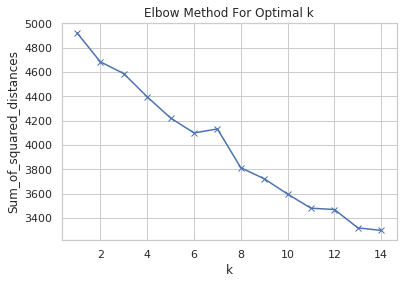

In [264]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [259]:
# set number of clusters
kclusters = 8

USAcity_grouped_clustering = USA_grouped.drop('City', 1)
print (USAcity_grouped_clustering.head())
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(USAcity_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

   Accessories Store  Adult Boutique  Afghan Restaurant  Airport  \
0               0.00             0.0               0.00      0.0   
1               0.01             0.0               0.00      0.0   
2               0.00             0.0               0.00      0.0   
3               0.00             0.0               0.00      0.0   
4               0.00             0.0               0.01      0.0   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop  Aquarium  \
0                 0.06           0.0             0.0           0.0      0.01   
1                 0.06           0.0             0.0           0.0      0.00   
2                 0.02           0.0             0.0           0.0      0.01   
3                 0.01           0.0             0.0           0.0      0.00   
4                 0.02           0.0             0.0           0.0      0.02   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0     0.0               0.0   

array([0, 2, 1, 5, 3, 7, 1, 3, 1, 1, 5, 5, 5, 0, 5, 2, 5, 0, 5, 5, 0, 5,
       1, 1, 5, 2, 3, 5, 1, 5, 1, 1, 0, 1, 1, 5, 0, 3, 5, 5, 1, 1, 7, 0,
       7, 5, 2, 5, 4, 6], dtype=int32)

In [260]:
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [261]:
USA_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
USA_merged = USA_merged.join(city_venues_sorted.set_index('City'), on='City')

USA_merged # check the last columns!

,Unnamed: 0,2018 rank,City,State,2018 estimate,2010 census,Change,2016 land area,2016 population density,Location,Area,State Abbr,city_coord,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,1,"New York, New York",New York,"8,398,748","8,175,133",2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",NY,"New York, United States of America",40.712728,-74.006015,1,Park,Italian Restaurant,Memorial Site,Garden,Bookstore
1,1,2,"Los Angeles, California",California,"3,990,456","3,792,621",5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",CA,"Los Angeles, Los Angeles County, California, U...",34.053691,-118.242767,1,Coffee Shop,Theater,Brewery,Hotel,Plaza
2,2,3,"Chicago, Illinois",Illinois,"2,705,994","2,695,598",0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",IL,"Chicago, Cook County, Illinois, United States ...",41.875562,-87.624421,3,Hotel,Grocery Store,Park,Italian Restaurant,New American Restaurant
3,3,4,"Houston, Texas",Texas,"2,325,502","2,100,263",10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",TX,"Houston, Harris County, Texas, United States o...",29.758938,-95.367697,5,Coffee Shop,Mexican Restaurant,Burger Joint,Hotel,Park
4,4,5,"Phoenix, Arizona",Arizona,"1,660,272","1,445,632",14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",AZ,"Phoenix, Maricopa County, Arizona, United Stat...",33.448437,-112.074142,0,Coffee Shop,Mexican Restaurant,Park,Pizza Place,Taco Place
5,5,6,"Philadelphia, Pennsylvania",Pennsylvania,"1,584,138","1,526,006",3.81%,134.2 sq mi,347.6 km2,"11,683/sq mi","4,511/km2",PA,"Philadelphia, Philadelphia County, Pennsylvani...",39.952724,-75.163526,5,Coffee Shop,Plaza,Park,Pizza Place,Grocery Store
6,6,7,"San Antonio, Texas",Texas,"1,532,233","1,327,407",15.43%,461.0 sq mi,"1,194.0 km2","3,238/sq mi","1,250/km2",TX,"San Antonio, Bexar County, Texas, United State...",29.424600,-98.495141,1,Hotel,Coffee Shop,Beer Garden,Brewery,Lounge
7,7,8,"San Diego, California",California,"1,425,976","1,307,402",9.07%,325.2 sq mi,842.3 km2,"4,325/sq mi","1,670/km2",CA,"San Diego, San Diego County, California, Unite...",32.717421,-117.162771,1,Hotel,Park,New American Restaurant,Italian Restaurant,Seafood Restaurant
8,8,9,"Dallas, Texas",Texas,"1,345,047","1,197,816",12.29%,340.9 sq mi,882.9 km2,"3,866/sq mi","1,493/km2",TX,"Dallas, Dallas County, Texas, United States of...",32.776272,-96.796856,5,Park,Coffee Shop,Burger Joint,American Restaurant,Hotel
9,9,10,"San Jose, California",California,"1,030,119","945,942",8.90%,177.5 sq mi,459.7 km2,"5,777/sq mi","2,231/km2",CA,"San Jose, Santa Clara County, California, Unit...",37.336191,-121.890583,0,Mexican Restaurant,Sandwich Place,Coffee Shop,Grocery Store,Bar


In [262]:
city_venues_sorted = city_venues_sorted.sort_values(by=['Cluster Labels'])
print (city_venues_sorted)

    Cluster Labels                               City 1st Most Common Venue  \
0                0           Albuquerque,  New Mexico    Mexican Restaurant   
36               0                  Phoenix,  Arizona           Coffee Shop   
20               0                 Las Vegas,  Nevada          Cocktail Bar   
17               0             Indianapolis,  Indiana                   Bar   
32               0               Oakland,  California           Coffee Shop   
43               0              San Jose,  California    Mexican Restaurant   
13               0                    El Paso,  Texas    Mexican Restaurant   
31               1                New York,  New York                  Park   
30               1            New Orleans,  Louisiana                 Hotel   
34               1                   Omaha,  Nebraska           Pizza Place   
28               1            Minneapolis,  Minnesota               Brewery   
23               1              Louisville,  Kentuck

In [266]:
city_venues_sorted.to_csv('city_venues_sorted.csv', index=False) 

In [267]:
import pandas as pd
city_venues_sorted = pd.read_csv('city_venues_sorted.csv')

In [268]:
print (city_venues_sorted.head())

   Cluster Labels                      City 1st Most Common Venue  \
0               0  Albuquerque,  New Mexico    Mexican Restaurant   
1               0         Phoenix,  Arizona           Coffee Shop   
2               0        Las Vegas,  Nevada          Cocktail Bar   
3               0    Indianapolis,  Indiana                   Bar   
4               0      Oakland,  California           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0               Brewery           Coffee Shop           Pizza Place   
1    Mexican Restaurant                  Park           Pizza Place   
2               Brewery    Mexican Restaurant           Coffee Shop   
3               Brewery    Mexican Restaurant           Coffee Shop   
4                Bakery                  Café           Beer Garden   

  5th Most Common Venue  
0   American Restaurant  
1            Taco Place  
2                Lounge  
3                 Hotel  
4    Mexican Restaurant  


In [273]:
df_city_den = df[['City', '2018 estimate', 'Area ']].copy()
df_city_den['2018 estimate'] = df_city_den['2018 estimate'].str.replace(',','')
df_city_den['2018 estimate'] = df_city_den['2018 estimate'].astype(int)
df_city_den['Area '] = df_city_den['Area '].str.replace(',','')
df_city_den['Area '] = df_city_den['Area '].str.replace('/km2','')
df_city_den['Area '] = df_city_den['Area '].astype(int)
df_city_den['Density'] = df_city_den['2018 estimate'] / df_city_den['Area ']

print (df_city_den.head())

                       City  2018 estimate  Area       Density
0       New York,  New York        8398748  10933   768.201592
1  Los Angeles,  California        3990456   3276  1218.087912
2        Chicago,  Illinois        2705994   4600   588.259565
3           Houston,  Texas        2325502   1395  1667.026523
4         Phoenix,  Arizona        1660272   1200  1383.560000


In [274]:
result = pd.merge(city_venues_sorted, df_city_den, on=['City'], how='inner')

In [275]:
print (result)

    Cluster Labels                               City 1st Most Common Venue  \
0                0           Albuquerque,  New Mexico    Mexican Restaurant   
1                0                  Phoenix,  Arizona           Coffee Shop   
2                0                 Las Vegas,  Nevada          Cocktail Bar   
3                0             Indianapolis,  Indiana                   Bar   
4                0               Oakland,  California           Coffee Shop   
5                0              San Jose,  California    Mexican Restaurant   
6                0                    El Paso,  Texas    Mexican Restaurant   
7                1                New York,  New York                  Park   
8                1            New Orleans,  Louisiana                 Hotel   
9                1                   Omaha,  Nebraska           Pizza Place   
10               1            Minneapolis,  Minnesota               Brewery   
11               1              Louisville,  Kentuck

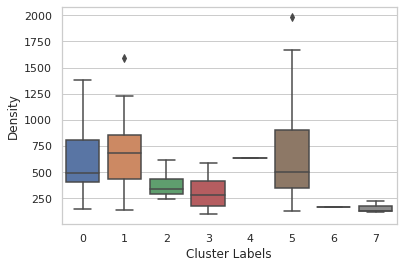

In [276]:
ax = sns.boxplot(x="Cluster Labels", y="Density", data=result)
plt.show()

In [278]:
summary = result[['Cluster Labels', 'City', '1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].copy()
print (summary)
summary.to_csv('Summary.csv')

    Cluster Labels                               City 1st Most Common Venue  \
0                0           Albuquerque,  New Mexico    Mexican Restaurant   
1                0                  Phoenix,  Arizona           Coffee Shop   
2                0                 Las Vegas,  Nevada          Cocktail Bar   
3                0             Indianapolis,  Indiana                   Bar   
4                0               Oakland,  California           Coffee Shop   
5                0              San Jose,  California    Mexican Restaurant   
6                0                    El Paso,  Texas    Mexican Restaurant   
7                1                New York,  New York                  Park   
8                1            New Orleans,  Louisiana                 Hotel   
9                1                   Omaha,  Nebraska           Pizza Place   
10               1            Minneapolis,  Minnesota               Brewery   
11               1              Louisville,  Kentuck

# References

1. Wikipedia: 
